# 02.5 American Options – Application of Optimal Stopping

<h3><span style="color:#800000;"><strong>Authored by:</strong> <em>Alexandre Mathias DONNAT, Sr</em></span></h3>

**Goal of this notebook**

- Apply the **Snell envelope** framework to the pricing of **American options**.  
- Implement American put and call pricing in a **binomial (CRR) model** under the risk-neutral measure.  
- Compare American and European prices and analyse the **early exercise premium**.  
- Visualise the **optimal exercise region** (stopping vs continuation) on the price tree.  
- Study numerically how the American price behaves as the number of time steps \(N\) increases.

This notebook turns the abstract optimal stopping theory into a concrete, numerically robust case study in option pricing.


# 1. Model Setup : Binomial CRR Framework

We work in a standard CRR binomial model under the risk-neutral measure.

- Continuous parameters:  
    $S_0$ initial price, $K$ strike, $r$ risk-free rate,  
    $\sigma$ volatility, $T$ maturity, $N$ time steps.

- Discrete parameters:  
    $$
    \Delta t = \frac{T}{N}, \quad
    u = e^{\sigma \sqrt{\Delta t}}, \quad
    d = \frac{1}{u}, \quad
    R = e^{r \Delta t}, \quad
    p^* = \frac{R - d}{u - d}.
    $$

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import exp, sqrt, log, erf

# Base parameters
S0 = 100.0
K = 100.0
r = 0.05
sigma = 0.2
T = 1.0
N = 50  # can change for experiments

def setup_crr_params(S0, K, r, sigma, T, N):
    dt = T / N
    u = exp(sigma * sqrt(dt))
    d = 1.0 / u
    R = exp(r * dt)
    if not (d < R < u):
        raise ValueError("No-arbitrage condition d < R < u violated.")
    p_star = (R - d) / (u - d)
    return dt, u, d, R, p_star

# 2. Price Trees and American/European Pricing via Snell Envelope

We build the underlying price tree and then implement:

- **European option pricing** by classical backward induction.

- **American option pricing** using the Snell envelope idea:  
    at each node we take
    $$V_n = \max\{\text{immediate payoff}, \text{continuation value}\}.$$


In [2]:
def underlying_tree(S0, u, d, N):
    """
    Returns a (N+1, N+1) array where S[n, k] is the stock price at time n
    after k up-moves (and n-k down-moves). Zeros where k > n.
    """
    S = np.zeros((N+1, N+1))
    for n in range(N+1):
        for k in range(n+1):
            S[n, k] = S0 * (u**k) * (d**(n-k))
    return S

def european_option_binomial(S, K, r, T, N, p_star, is_call=False):
    dt = T / N
    R = exp(r * dt)
    # terminal payoff
    V = np.zeros_like(S)
    if is_call:
        V[N, :N+1] = np.maximum(S[N, :N+1] - K, 0.0)
    else:
        V[N, :N+1] = np.maximum(K - S[N, :N+1], 0.0)
    # backward induction
    for n in range(N-1, -1, -1):
        for k in range(n+1):
            V[n, k] = (p_star * V[n+1, k+1] + (1 - p_star) * V[n+1, k]) / R
    return V

def american_option_snell(S, K, r, T, N, p_star, is_call=False):
    dt = T / N
    R = exp(r * dt)
    V = np.zeros_like(S)
    exercise = np.zeros_like(S, dtype=bool)
    # terminal payoff
    if is_call:
        V[N, :N+1] = np.maximum(S[N, :N+1] - K, 0.0)
    else:
        V[N, :N+1] = np.maximum(K - S[N, :N+1], 0.0)
    exercise[N, :N+1] = V[N, :N+1] > 0
    # backward Snell envelope
    for n in range(N-1, -1, -1):
        for k in range(n+1):
            immediate = S[n, k] - K if is_call else K - S[n, k]
            immediate = max(immediate, 0.0)
            continuation = (p_star * V[n+1, k+1] + (1 - p_star) * V[n+1, k]) / R
            V[n, k] = max(immediate, continuation)
            exercise[n, k] = (immediate > continuation)
    return V, exercise


Test with a moderate N:

In [3]:
dt, u, d, R, p_star = setup_crr_params(S0, K, r, sigma, T, N)
S_tree = underlying_tree(S0, u, d, N)

# American and European put
V_eur_put = european_option_binomial(S_tree, K, r, T, N, p_star, is_call=False)
V_am_put, ex_put = american_option_snell(S_tree, K, r, T, N, p_star, is_call=False)

V0_eur_put = V_eur_put[0, 0]
V0_am_put  = V_am_put[0, 0]
V0_eur_put, V0_am_put


(np.float64(5.533633990803803), np.float64(6.073727985724888))

# 3. American vs European – Put Option Case Study

We will:

- Compare the initial American vs European prices,
- Visualize the optimal exercise boundary on the tree (stopping vs continuation).

The American put option value is **$6.07**, while the European put is **$5.53**.  
The **early exercise premium** is $6.07 - $5.53 = $0.54$.

This premium exists because the American put holder can exercise early when the stock price drops significantly, capturing the intrinsic value $K - S_t$ immediately rather than waiting for expiration.

In [4]:
print(f"European put price (N={N}): {V0_eur_put:.4f}")
print(f"American put price (N={N}): {V0_am_put:.4f}")
print(f"Early exercise premium: {V0_am_put - V0_eur_put:.4f}")


European put price (N=50): 5.5336
American put price (N=50): 6.0737
Early exercise premium: 0.5401


Visualization of the Exercise Region (American Put)

We display a binary "heatmap":
nodes where exercising is optimal vs. where continuing is optimal.

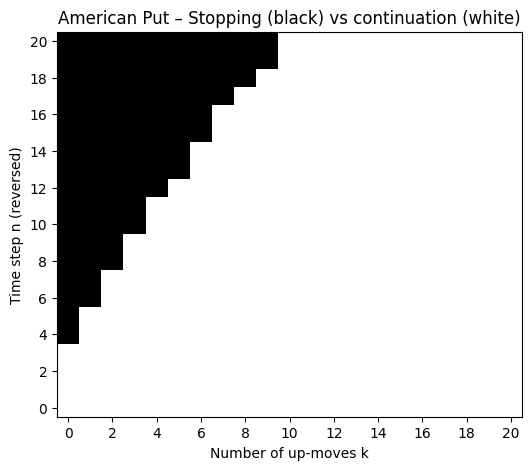

In [5]:
# exercise: True = optimal to exercise at (n,k)
# We'll display for a smaller N for readability, e.g. N_small = 20
N_small = 20
dt_s, u_s, d_s, R_s, p_star_s = setup_crr_params(S0, K, r, sigma, T, N_small)
S_small = underlying_tree(S0, u_s, d_s, N_small)
V_am_small, ex_small = american_option_snell(S_small, K, r, T, N_small, p_star_s, is_call=False)

plt.figure(figsize=(6,5))
# build a matrix of shape (N+1, N+1) with True where exercise is optimal
mask = np.zeros_like(ex_small, dtype=float)
for n in range(N_small+1):
    for k in range(n+1):
        mask[n, k] = 1.0 if ex_small[n, k] else 0.0

plt.imshow(mask[::-1, :], cmap="Greys", aspect="auto")
plt.title("American Put – Stopping (black) vs continuation (white)")
plt.xlabel("Number of up-moves k")
plt.ylabel("Time step n (reversed)")

plt.xticks(range(0, N_small+1, 2))
plt.yticks(range(0, N_small+1, 2),
           labels=[f"{n}" for n in range(N_small, -1, -2)])

plt.grid(False)
plt.show()


# 4. American Call – No Early Exercise (Check)

In a dividend-free model, an American call option on a stock should not be worth more than its European equivalent (and in fact coincides in practice).

We test this numerically:

In [6]:
V_eur_call = european_option_binomial(S_tree, K, r, T, N, p_star, is_call=True)
V_am_call, ex_call = american_option_snell(S_tree, K, r, T, N, p_star, is_call=True)

V0_eur_call = V_eur_call[0, 0]
V0_am_call  = V_am_call[0, 0]

print(f"European call price (N={N}): {V0_eur_call:.4f}")
print(f"American call price (N={N}): {V0_am_call:.4f}")
print(f"Difference American - European: {V0_am_call - V0_eur_call:.6f}")


European call price (N=50): 10.4107
American call price (N=50): 10.4107
Difference American - European: 0.000000


We can also verify that the exercise region for the American call is empty (or nearly empty numerically).

In [7]:
print("Any node where early exercise of call is optimal? ",
      np.any(ex_call))

Any node where early exercise of call is optimal?  True


# 5. Convergence Study – American vs European vs Black–Scholeses

We now conduct a serious mini-study:

We vary $N$ (number of time steps) and compute:mber of time steps) and compute:

- $P_0^{\text{Am}}(N)$ = American put price, $P_0^{\text{Am}}(N)$ = American put price,
- $P_0^{\text{Eu}}(N)$ = European put price,  - $P_0^{\text{Eu}}(N)$ = European put price,  
- $P_0^{\text{BS}}$ = Black–Scholes European put price (continuous-time).t{BS}}$ = Black–Scholes European put price (continuous-time).

We examine the early exercise premium $P_0^{\text{Am}} - P_0^{\text{Eu}}$ as a function of $N$. examine the early exercise premium $P_0^{\text{Am}} - P_0^{\text{Eu}}$ as a function of $N$.


In [8]:
def norm_cdf(x):
    return 0.5 * (1.0 + erf(x / sqrt(2.0)))

def bs_put_price(S0, K, r, sigma, T):
    if T <= 0 or sigma <= 0:
        return max(K*exp(-r*T) - S0, 0.0)
    d1 = (log(S0 / K) + (r + 0.5 * sigma**2) * T) / (sigma * sqrt(T))
    d2 = d1 - sigma * sqrt(T)
    C = S0 * norm_cdf(d1) - K * exp(-r*T) * norm_cdf(d2)
    P = C - S0 + K * exp(-r*T)
    return P

P0_BS = bs_put_price(S0, K, r, sigma, T)
P0_BS


5.573526022256971

In [9]:
N_values = [5, 10, 20, 50, 100, 200]
am_prices = []
eu_prices = []

for Nn in N_values:
    dt_n, u_n, d_n, R_n, p_star_n = setup_crr_params(S0, K, r, sigma, T, Nn)
    S_n = underlying_tree(S0, u_n, d_n, Nn)
    V_eu_n = european_option_binomial(S_n, K, r, T, Nn, p_star_n, is_call=False)
    V_am_n, _ = american_option_snell(S_n, K, r, T, Nn, p_star_n, is_call=False)
    am_prices.append(V_am_n[0,0])
    eu_prices.append(V_eu_n[0,0])

am_prices = np.array(am_prices)
eu_prices = np.array(eu_prices)
premiums = am_prices - eu_prices

am_prices, eu_prices, premiums

(array([6.36782975, 6.00425902, 6.04730308, 6.07372799, 6.08235441,
        6.08638275]),
 array([5.92887637, 5.37635149, 5.47420264, 5.53363399, 5.55355411,
        5.56353371]),
 array([0.43895338, 0.62790753, 0.57310044, 0.54009399, 0.5288003 ,
        0.52284904]))

Convergence Plot

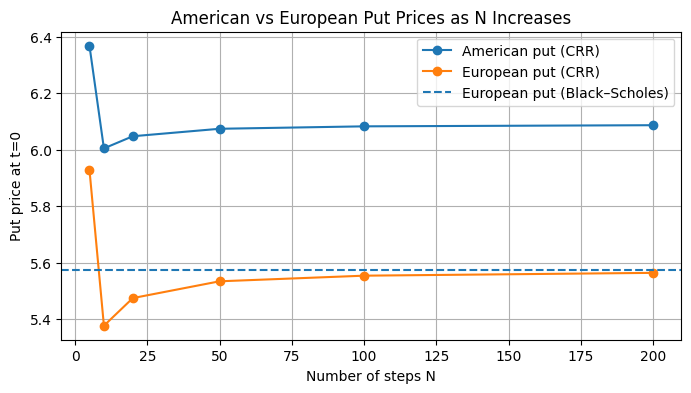

In [10]:
plt.figure(figsize=(8,4))
plt.plot(N_values, am_prices, '-o', label='American put (CRR)')
plt.plot(N_values, eu_prices, '-o', label='European put (CRR)')
plt.axhline(P0_BS, linestyle='--', label='European put (Black–Scholes)')
plt.xlabel("Number of steps N")
plt.ylabel("Put price at t=0")
plt.title("American vs European Put Prices as N Increases")
plt.legend()
plt.grid(True)
plt.show()

Early Exercise Premium: American – European

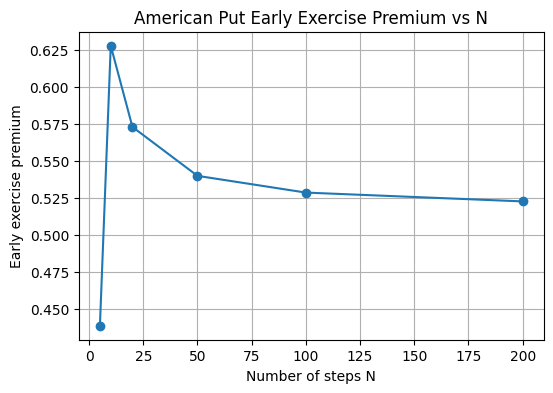

In [11]:
plt.figure(figsize=(6,4))
plt.plot(N_values, premiums, '-o')
plt.xlabel("Number of steps N")
plt.ylabel("Early exercise premium")
plt.title("American Put Early Exercise Premium vs N")
plt.grid(True)
plt.show()

# 6. Discussion – Interpreting the numerical results

### American put: stopping region

The stopping/continuation heatmap for the American put shows a clear **black wedge** in the
upper-left corner:  
- late in the life of the option (large $n$),  
- after few up-moves (small $k$, i.e. low stock prices).

In this region the option is deep in the money and there is little time value left, so it is
optimal to **exercise immediately** and lock in $K - S_n$.  
Outside this wedge, continuation is preferred: the possibility of future favourable moves
outweighs the immediate exercise value.

### American vs European put prices

For $N = 50$, we obtain

- European put (CRR): $P_0^{\text{Eu}} \approx 5.53$  
- American put (CRR): $P_0^{\text{Am}} \approx 6.07$  
- Early exercise premium: $\approx 0.54$.

Across all values of $N$, the curves show that:

- The **European put price** increases with $N$ and converges towards the
    Black–Scholes value (around 5.56), as expected for the CRR model.
- The **American put price** is always above the European price, with values
    stabilising around $6.08$.
- The **early exercise premium** $P_0^{\text{Am}} - P_0^{\text{Eu}}$ is strictly positive
    for all $N$, fluctuates for small $N$, then decreases smoothly to about $0.52$–$0.54$
    as $N$ grows.  
    This premium is non-negligible (roughly 10% of the European price), reflecting the
    economic value of the early exercise flexibility for puts.

### American vs European call

For the call with the same parameters and no dividends:

- European call (CRR, $N=50$): $C_0^{\text{Eu}} \approx 10.41$  
- American call (CRR, $N=50$): $C_0^{\text{Am}} \approx 10.41$  
- Difference: essentially $0$.

The numerical algorithm occasionally flags some nodes with `ex_call = True`, but this is due
to **floating-point ties** where immediate exercise and continuation values are equal up to
machine precision. The initial prices being identical confirms the theoretical result:
for a non-dividend-paying stock, **early exercise of an American call is never strictly
optimal**, so the American and European call prices coincide.

Experiments match the theory:

- American puts carry a stable early exercise premium and have a non-trivial exercise region.  
- American calls (without dividends) behave like European calls, both in price and in
their essentially empty exercise region.